# Analyzing SASUMO outputs

### Import the Required Libraries

In [1]:
# %%capture
# !pip install SALib
# !pip install pint-pandas
# !pip install pint
# !pip install plotly
# !pip install lxml

In [1]:
import os
import sys

In [2]:
def find_root(path):
    if os.path.split(path)[-1] != 'airport-harper-sumo':
        return find_root(os.path.split(path)[0])
    return path

In [3]:
PATH = !pwd  # a bit of Jupyter Magic to get the working path
PATH = find_root(PATH[0])
if PATH not in sys.path:
    print(f"adding {PATH} to path")
    sys.path.append(PATH)

# Add savvy to the path
sys.path.append(os.path.join(os.getcwd(), 'savvy',))

adding /home/max/remote/airport-harper-sumo to path


In [4]:
import json
import sys
import pickle
import csv
import copy

import numpy as np
import pandas as pd 
import pint
import pint_pandas
import plotly.graph_objects as go

from SALib.analyze import sobol
from SASUMO.params import Settings4SASUMO

In [5]:
ureg = pint.UnitRegistry()

## Defining the Analysis Root

In [6]:
ROOT = r"/media/HDD/max/sasumo-files/Car_Following_Params_V2_630AM/2021_10_06-10_11_53"
TOP_LEVEL_SETTINGS = os.path.join(ROOT, "settings.yaml")
OUTPUT= os.path.join(ROOT, "output.txt")
PROBLEM = os.path.join(ROOT, "SALib_Problem.json")

In [7]:
# with open(TOP_LEVEL_SETTINGS, 'rb') as f:
settings = Settings4SASUMO(TOP_LEVEL_SETTINGS)

## Open up the Problem

In [8]:
with open(PROBLEM, 'r') as f:
    problem = json.load(f)
problem

{'num_vars': 6,
 'names': ['PersonalCar_tau',
  'PersonalCar_delta',
  'PersonalCar_accel',
  'PersonalCar_decel',
  'PersonalCar_speedFactor',
  'PersonalCar_minGap'],
 'bounds': [[0.5, 3], [1, 10], [3, 6], [3, 7], [0.75, 1.5], [0.5, 3]]}

## Creating a table of the Results and Parameters

In [82]:
results = []
param_keys = []
cal_keys = []
for _dir in os.scandir(ROOT):
    if _dir.is_dir():
        # reading the fuel consumption in 
        try:
            with open(os.path.join(_dir.path, 'f_out.txt'), 'r') as f:
                fc = float(f.read())
        except:
            print(f"issue with {_dir.path}")
        with open(os.path.join(_dir.path, 'sa_values.json'), 'r') as f:
            _d = json.loads(f.read())
            if not param_keys:
                param_keys = list(_d.keys())
            params = [_d[_k] for _k in param_keys]
        
        # load the calibration results
        with open(os.path.join(_dir.path, 'calibration_results.json'), 'r') as f:
            _d = json.loads(f.read())
            if not cal_keys:
                cal_keys = ["-".join([key, movement, sigma]) for key in _d.keys() for movement in ["WB", "EB"] for sigma in ['sigma_1', 'sigma_1.96']]
            cal_results = []
            for cal_key in cal_keys:
                l1, l2, l3 = cal_key.split("-")
                cal_results.append(_d[l1][l2][l3])
#             for key, item in _d.items():
#                 for movement, inner_item in item.items():
#                     for measure, val in inner_item.items():
#                         if "_".join([key, movement, measure]) in cal_keys:
#                             cal_results.append(val)
        
        results.append([int(_dir.name.split("_")[1]), fc, *params, *cal_results])

In [94]:
results_df = pd.DataFrame.from_records(results, columns=['Sample_Num', 'f_out', *param_keys, *cal_keys],)
results_df.set_index('Sample_Num', inplace=True)
results_df.sort_index(inplace=True)
results_np = results_df['f_out'].values

In [95]:
results_df['Fuel [gal]'] = results_df['f_out'] * (1* ureg.milliliter).to('gallon').magnitude
results_df.tail()

,f_out,PersonalCar_tau,PersonalCar_delta,PersonalCar_accel,PersonalCar_decel,PersonalCar_speedFactor,PersonalCar_minGap,63082002-WB-sigma_1,63082002-WB-sigma_1.96,63082002-EB-sigma_1,63082002-EB-sigma_1.96,63082003-WB-sigma_1,63082003-WB-sigma_1.96,63082003-EB-sigma_1,63082003-EB-sigma_1.96,63082004-WB-sigma_1,63082004-WB-sigma_1.96,63082004-EB-sigma_1,63082004-EB-sigma_1.96,Fuel [gal]
Sample_Num,,,,,,,,,,,,,,,,,,,,
1787,244773.249,1.105469,1.632812,4.664062,5.15625,1.212891,1.964844,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.923077,1.0,0.923077,1.0,64.662252
1788,242899.162,1.105469,1.632812,4.242188,5.53125,1.212891,1.964844,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.923077,1.0,1.000000,1.0,64.167170
1789,228775.067,1.105469,1.632812,4.242188,5.15625,1.107422,1.964844,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.923077,1.0,1.000000,1.0,60.435979
1790,241581.192,1.105469,1.632812,4.242188,5.15625,1.212891,1.339844,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.923077,1.0,1.000000,1.0,63.818999
1791,243460.700,1.105469,1.632812,4.242188,5.15625,1.212891,1.964844,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.923077,1.0,0.923077,1.0,64.315513


## Create the Calibration Score

In [103]:
for key in cal_keys:
    res = (0.95 - results_df[key] if '1.96' in key else 0.666 - results_df[key])
    res[res < 0] = 0
    results_df[key+"_score"] = 1 - res    

In [104]:
results_df['cal_score'] = results_df[[key+"_score" for key in cal_keys]].mean(axis=1)
results_df.drop([key+"_score" for key in cal_keys], inplace=True, axis=1)

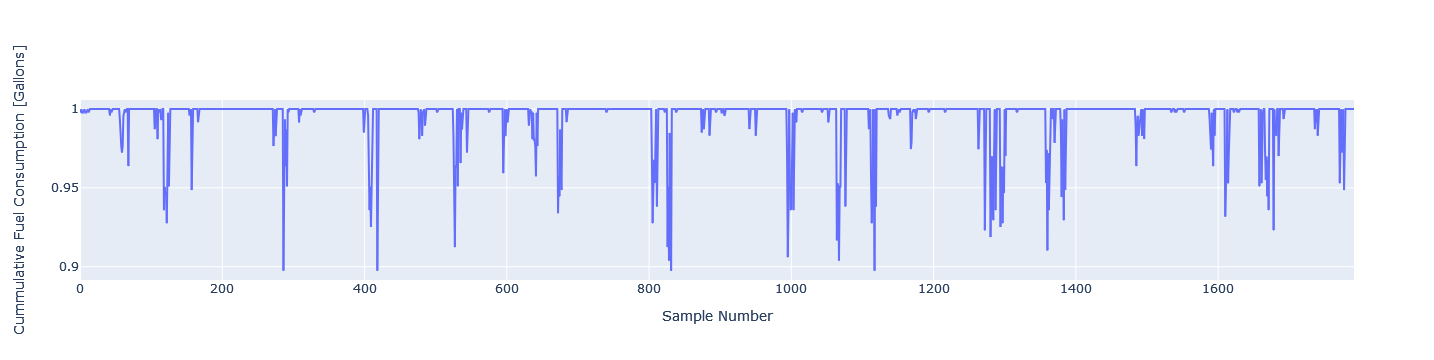

In [105]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=results_df.index, y=results_df['cal_score'], mode='lines'))
fig.update_layout(yaxis=dict(title="Cummulative Fuel Consumption [Gallons]"),
                  xaxis=dict(title='Sample Number')
                 )
fig.show()

In [115]:
results_df.sort_values('cal_score',).head()

,f_out,PersonalCar_tau,PersonalCar_delta,PersonalCar_accel,PersonalCar_decel,PersonalCar_speedFactor,PersonalCar_minGap,63082002-WB-sigma_1,63082002-WB-sigma_1.96,63082002-EB-sigma_1,...,63082003-WB-sigma_1,63082003-WB-sigma_1.96,63082003-EB-sigma_1,63082003-EB-sigma_1.96,63082004-WB-sigma_1,63082004-WB-sigma_1.96,63082004-EB-sigma_1,63082004-EB-sigma_1.96,Fuel [gal],cal_score
Sample_Num,,,,,,,,,,,,,,,,,,,,,
831,195606.587999,1.476562,7.046875,5.953125,5.31250,1.160156,0.539062,0.538462,0.923077,1.0,...,0.307692,0.692308,0.923077,1.0,0.923077,1.0,0.461538,0.692308,51.673794,0.897282
418,194958.355000,0.734375,3.531250,5.718750,4.37500,1.335938,0.578125,0.307692,0.923077,1.0,...,0.307692,0.769231,1.000000,1.0,0.923077,1.0,0.461538,0.846154,51.502549,0.897282
1117,177900.860999,1.691406,4.585938,5.789062,5.71875,0.814453,0.597656,0.461538,0.846154,1.0,...,0.384615,0.846154,0.923077,1.0,0.923077,1.0,0.384615,0.692308,46.996436,0.897282
286,178005.977999,1.671875,1.843750,5.531250,4.12500,0.867188,0.578125,0.384615,0.846154,1.0,...,0.538462,0.846154,1.000000,1.0,0.923077,1.0,0.307692,0.692308,47.024205,0.897282
828,198544.560000,1.476562,7.890625,5.953125,5.31250,1.300781,0.539062,0.384615,0.923077,1.0,...,0.384615,0.769231,0.923077,1.0,0.923077,1.0,0.461538,0.769231,52.449924,0.903692


## Display the top Fuel Consumers

In [106]:
results_df.sort_values('f_out', ascending=False)

,f_out,PersonalCar_tau,PersonalCar_delta,PersonalCar_accel,PersonalCar_decel,PersonalCar_speedFactor,PersonalCar_minGap,63082002-WB-sigma_1,63082002-WB-sigma_1.96,63082002-EB-sigma_1,...,63082003-WB-sigma_1,63082003-WB-sigma_1.96,63082003-EB-sigma_1,63082003-EB-sigma_1.96,63082004-WB-sigma_1,63082004-WB-sigma_1.96,63082004-EB-sigma_1,63082004-EB-sigma_1.96,Fuel [gal],cal_score
Sample_Num,,,,,,,,,,,,,,,,,,,,,
1038,326577.410001,2.902344,1.210938,4.148438,6.59375,1.470703,2.707031,1.000000,1.0,1.0,...,1.000000,1.0,1.000000,1.0,0.923077,1.0,0.846154,1.000000,86.272625,1.000000
1749,318261.824002,2.980469,3.882812,3.492188,6.15625,1.400391,2.589844,1.000000,1.0,1.0,...,1.000000,1.0,1.000000,1.0,0.923077,1.0,1.000000,1.000000,84.075879,1.000000
1036,315387.616002,2.902344,5.148438,4.148438,6.59375,1.470703,2.707031,1.000000,1.0,1.0,...,1.000000,1.0,1.000000,1.0,0.923077,1.0,1.000000,1.000000,83.316594,1.000000
1745,315285.943002,2.980469,3.882812,3.914062,6.15625,1.400391,2.589844,1.000000,1.0,1.0,...,1.000000,1.0,1.000000,1.0,0.923077,1.0,1.000000,1.000000,83.289735,1.000000
337,315195.521001,2.921875,2.406250,4.593750,6.37500,1.382812,2.140625,1.000000,1.0,1.0,...,1.000000,1.0,1.000000,1.0,0.923077,1.0,1.000000,1.000000,83.265848,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,151944.096999,0.500000,1.000000,3.000000,3.00000,0.750000,0.500000,0.846154,1.0,1.0,...,0.846154,1.0,1.000000,1.0,0.923077,1.0,0.692308,0.923077,40.139384,0.997756
11,151768.607999,0.500000,1.000000,3.000000,3.00000,0.750000,0.500000,0.846154,1.0,1.0,...,0.846154,1.0,1.000000,1.0,0.923077,1.0,0.692308,1.000000,40.093025,1.000000
13,151629.391999,0.500000,1.000000,3.000000,3.00000,0.750000,0.500000,0.846154,1.0,1.0,...,0.769231,1.0,1.000000,1.0,0.923077,1.0,0.769231,1.000000,40.056248,1.000000


## Perform the Sobol Analysis

In [107]:
Si = sobol.analyze(problem, results_df.sort_index()['cal_score'].values, print_to_console=False, calc_second_order=True)

In [108]:
sensitivity_df = Si.to_df()[0].join(Si.to_df()[1])
sensitivity_df

,ST,ST_conf,S1,S1_conf
PersonalCar_tau,0.243952,0.209733,0.031918,0.038379
PersonalCar_delta,0.134632,0.089935,0.017959,0.037775
PersonalCar_accel,0.451859,0.249227,0.038090,0.086596
PersonalCar_decel,0.090618,0.048461,0.013474,0.021079
PersonalCar_speedFactor,0.155400,0.117308,0.016422,0.030082
PersonalCar_minGap,1.280730,0.731194,0.652520,0.510175


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

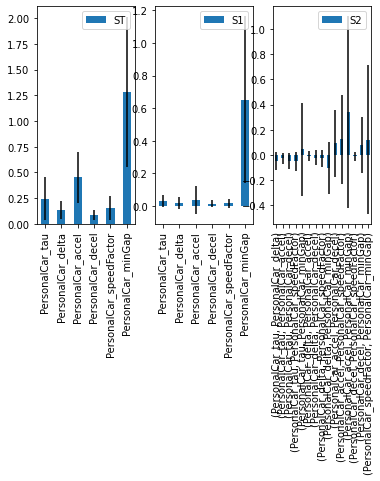

In [109]:
Si.plot()

## Plotting with Plotly

In [110]:
import plotly.graph_objects as go
# import plotly.

In [111]:
names = ["Tau", "Delta",  "Accel", "Deccel", "Speed Factor", "Min Gap"]

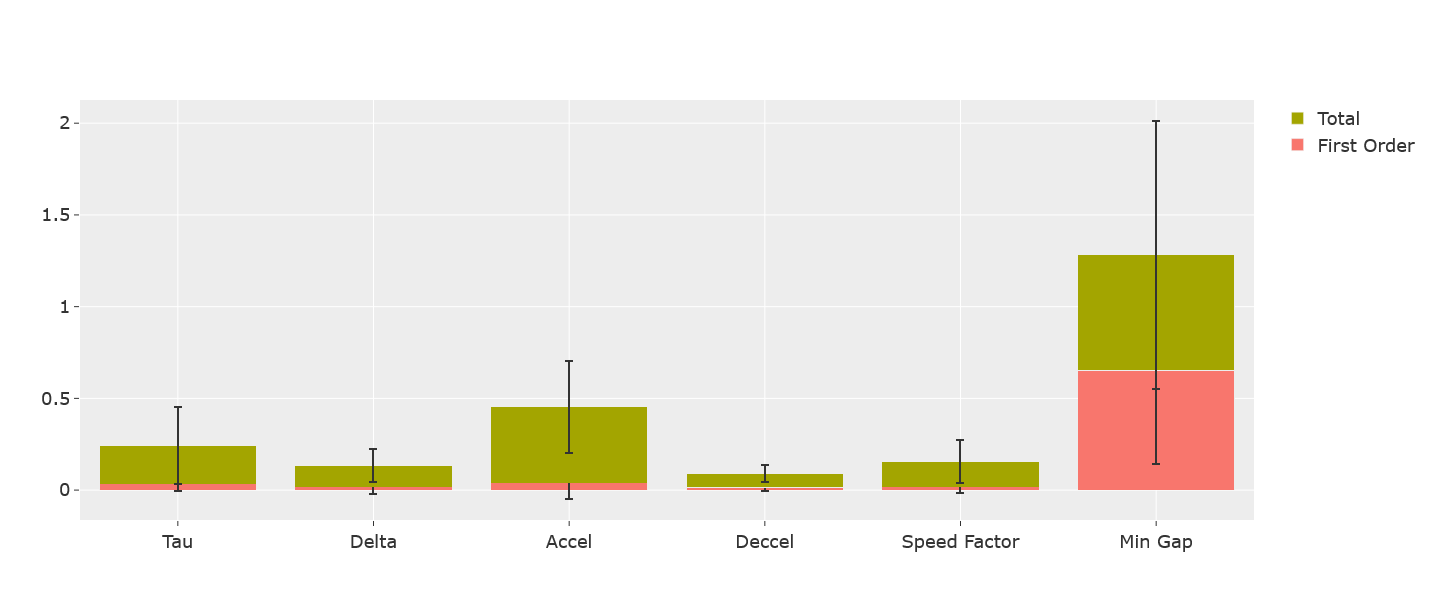

In [112]:
fig = go.Figure()


fig.add_trace(go.Bar(x=names, y=sensitivity_df['S1'], name="First Order", error_y=dict(type='data', array=sensitivity_df['S1_conf'].values)))
fig.add_trace(go.Bar(x=names, y=sensitivity_df['ST'] - sensitivity_df['S1'], name="Total", error_y=dict(type='data', array=sensitivity_df['ST_conf'].values)))

fig.update_layout(barmode='stack', template='ggplot2', height=600, width=1200, font_size=18)

fig.show()

In [71]:
results_df.sort_values('calibration_score')

,f_out,PersonalCar_tau,PersonalCar_delta,PersonalCar_accel,PersonalCar_decel,PersonalCar_speedFactor,PersonalCar_minGap,63082002-WB-sigma_1,63082002-EB-sigma_1,63082003-WB-sigma_1,63082003-EB-sigma_1,63082004-WB-sigma_1,63082004-EB-sigma_1,Fuel [gal],calibration_score
Sample_Num,,,,,,,,,,,,,,,
1067,178446.485999,1.339844,4.023438,5.039062,4.09375,1.001953,0.519531,0.384615,1.0,0.384615,1.000000,0.923077,0.307692,47.140574,0.666667
418,194958.355000,0.734375,3.531250,5.718750,4.37500,1.335938,0.578125,0.307692,1.0,0.307692,1.000000,0.923077,0.461538,51.502549,0.666667
826,203940.871000,1.476562,7.046875,5.953125,5.31250,1.300781,0.539062,0.384615,1.0,0.307692,0.923077,0.923077,0.538462,53.875478,0.679487
828,198544.560000,1.476562,7.890625,5.953125,5.31250,1.300781,0.539062,0.384615,1.0,0.384615,0.923077,0.923077,0.461538,52.449924,0.679487
1117,177900.860999,1.691406,4.585938,5.789062,5.71875,0.814453,0.597656,0.461538,1.0,0.384615,0.923077,0.923077,0.384615,46.996436,0.679487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1690,232377.863000,2.042969,7.257812,5.367188,5.03125,0.931641,2.277344,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,61.387737,1.000000
937,256770.071000,2.785156,9.648438,4.476562,6.46875,0.896484,2.941406,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,67.831477,1.000000
958,253939.659000,1.496094,1.210938,4.335938,3.84375,1.330078,1.378906,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,67.083761,1.000000


### Fleet Composition vs. Fuel Consumption

### The mean line

In [34]:
from sklearn.linear_model import LinearRegression

In [47]:
model = LinearRegression().fit(results_df['PersonalCar_speedFactor'].values.reshape((-1, 1)), results_df['Fuel [gal]'].values)
fit_fuel = model.predict(results_df['PersonalCar_speedFactor'].unique().reshape((-1, 1)))

mean_df = results_df[['Fuel [gal]', 'PersonalCar_speedFactor']].groupby('PersonalCar_speedFactor').mean()

In [48]:
r_sq = model.score(results_df['PersonalCar_speedFactor'].values.reshape((-1, 1)), results_df['Fuel [gal]'].values)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.48228970013578


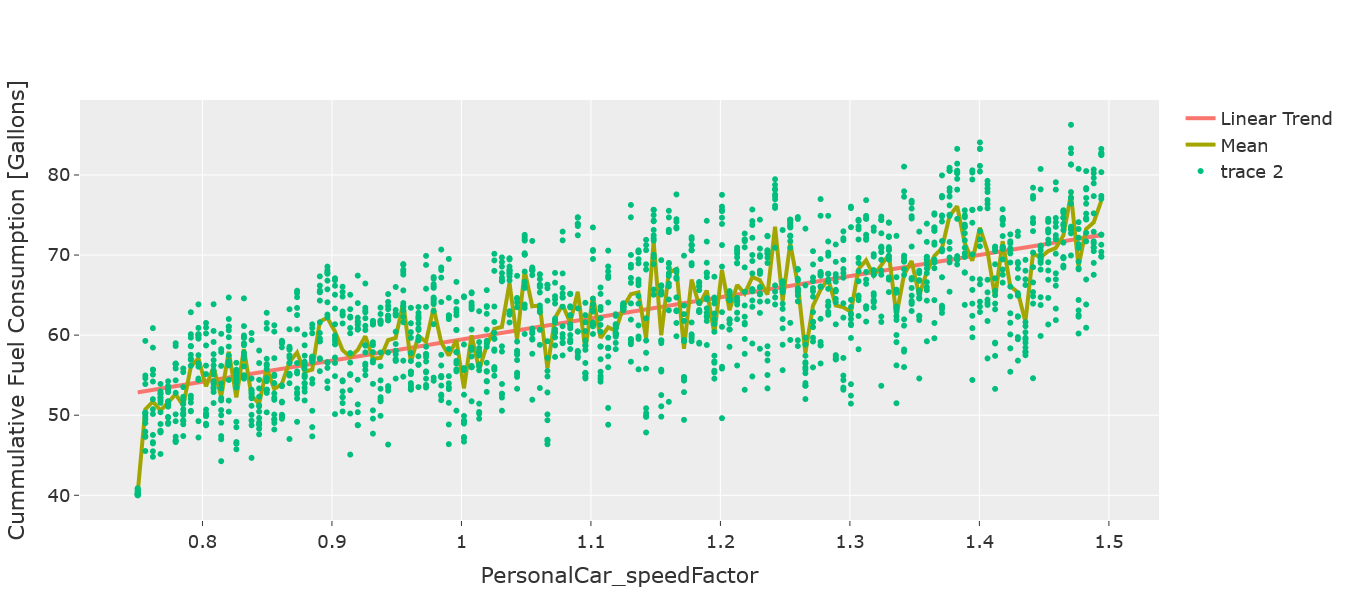

In [117]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=results_df['PersonalCar_speedFactor'].unique(), y=fit_fuel, mode='lines', line_width=4, name="Linear Trend"), )

fig.add_trace(go.Scatter(x=mean_df.index, y=mean_df['Fuel [gal]'], mode='lines', line_width=4, name="Mean"))

fig.add_trace(go.Scatter(x=results_df['PersonalCar_speedFactor'], y=results_df['Fuel [gal]'], mode='markers', 
                         customdata=results_df.index, hovertemplate='sample num:%{customdata:.0f}<br>val:%{y:.3f}'))

fig.update_layout(yaxis=dict(title="Cummulative Fuel Consumption [Gallons]"),
                  xaxis=dict(title='PersonalCar_speedFactor')
                 )

fig.update_layout(barmode='stack', template='ggplot2', height=600, width=1200, font_size=18)
# fig.update_layout(hovermode="x unified")

fig.show()

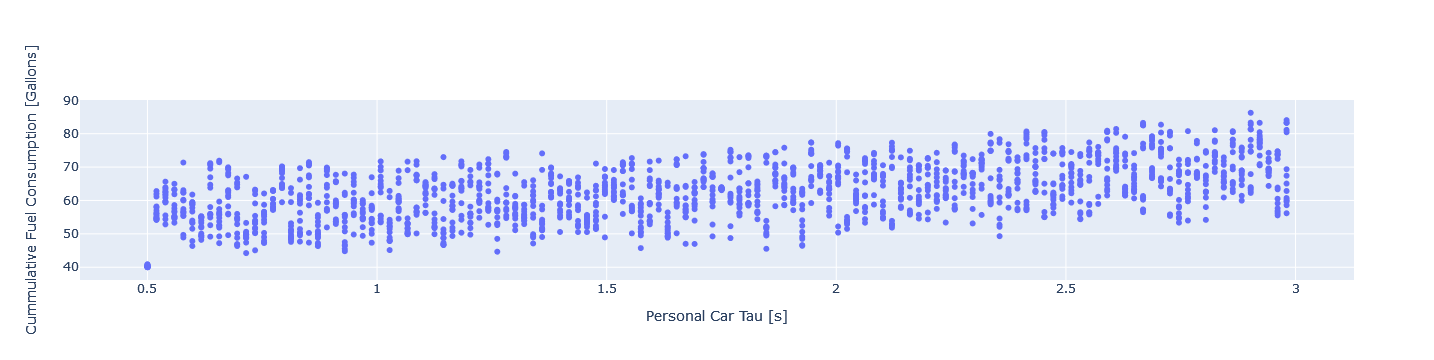

In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=results_df['PersonalCar_tau'], y=results_df['Fuel [gal]'], mode='markers'))
fig.update_layout(yaxis=dict(title="Cummulative Fuel Consumption [Gallons]"),
                  xaxis=dict(title='Personal Car Tau [s]')
                 )
fig.show()

In [32]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=results_df['CarFollowingParameters_delta'], y=results_df['Fuel [gal]'], mode='markers'))
# fig.update_layout(yaxis=dict(title="Cummulative Fuel Consumption [Gallons]"),
#                   xaxis=dict(title='Personal Car Delta')
#                  )
# fig.show()

In [33]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=results_df['PersonalCar_accel'], y=results_df['Fuel [gal]'], mode='markers'))
# fig.update_layout(yaxis=dict(title="Cummulative Fuel Consumption [Gallons]"),
#                   xaxis=dict(title='Personal Car Accel [m/s^2]')
#                  )
# fig.show()

In [34]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=results_df['Class8Truck_tau'], y=results_df['Fuel [gal]'], mode='markers'))
# fig.update_layout(yaxis=dict(title="Cummulative Fuel Consumption [Gallons]"),
#                   xaxis=dict(title='Class8Truck Tau [s]')
#                  )
# fig.show()

In [35]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=results_df['Class8Truck_delta'], y=results_df['Fuel [gal]'], mode='markers'))
# fig.update_layout(yaxis=dict(title="Cummulative Fuel Consumption [Gallons]"),
#                   xaxis=dict(title='Class8Truck Delta')
#                  )
# fig.show()

In [36]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=results_df['Class8Truck_accel'], y=results_df['Fuel [gal]'], mode='markers'))
# fig.update_layout(yaxis=dict(title="Cummulative Fuel Consumption [Gallons]"),
#                   xaxis=dict(title='Class8Truck Accel [m/s^2]')
#                  )
# fig.show()